In [2]:
import torch
from torch import nn
from layers import Conv, Hourglass, Pool, Residual
from loss import HeatmapLoss

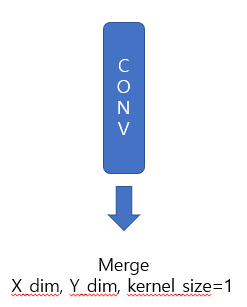

In [3]:
class Merge(nn.Module):
    def __init__(self, x_dim, y_dim):
        super(Merge, self).__init__()
        self.conv = Conv(x_dim, y_dim, 1, relu=False, bn=False)

    def forward(self, x):
        return self.conv(x)

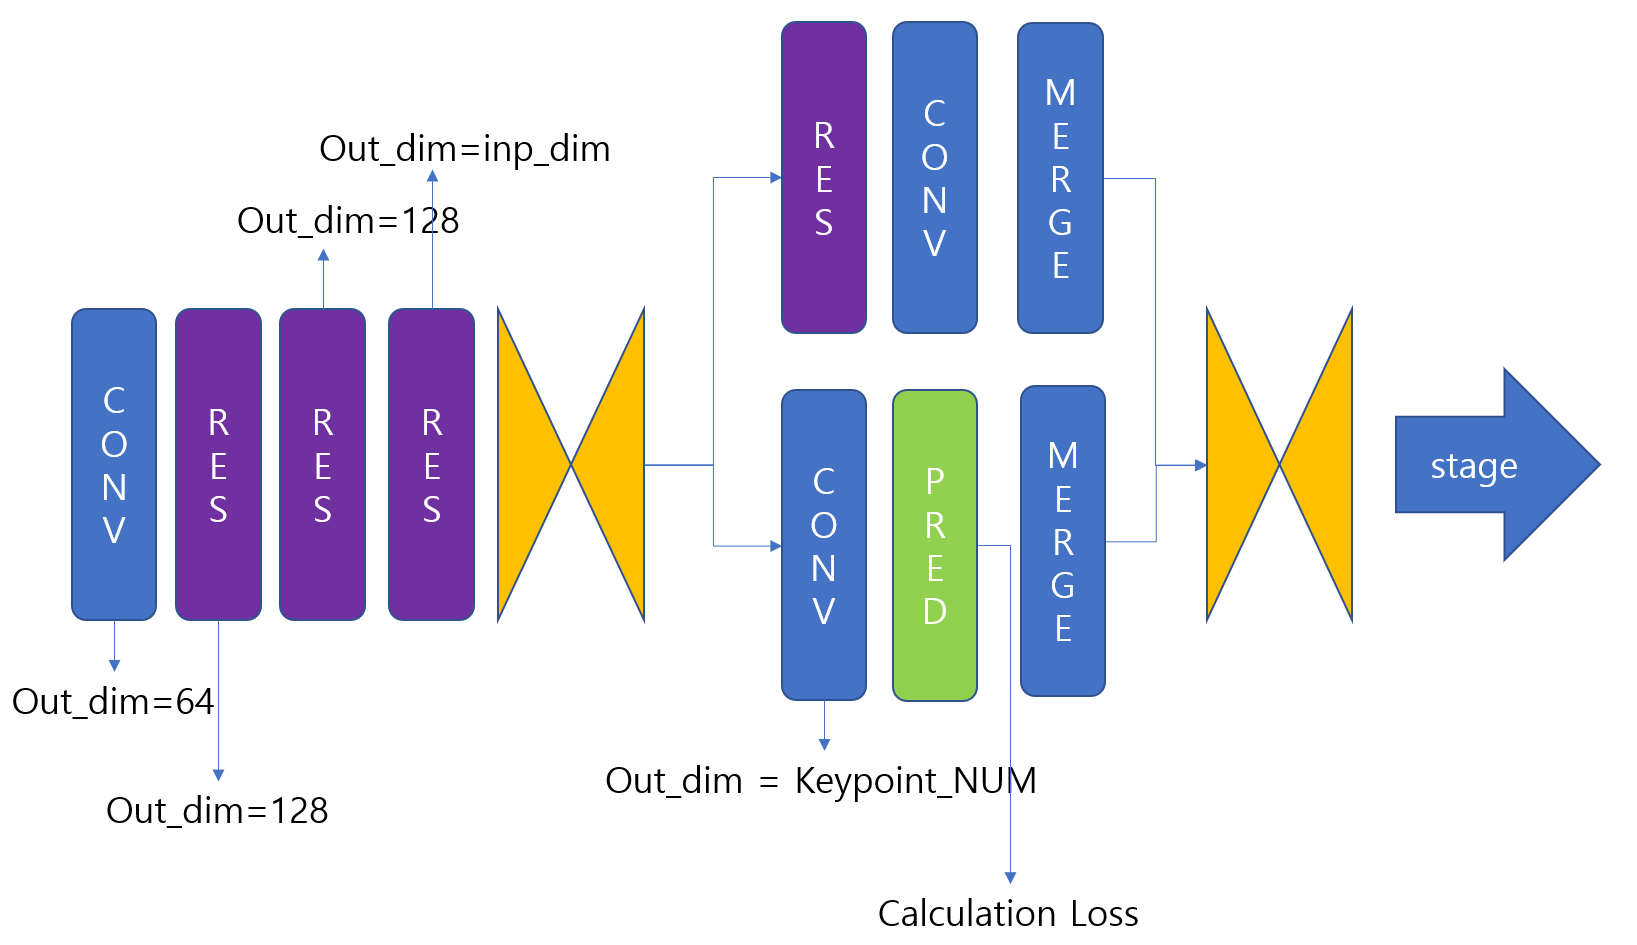

In [4]:
class PoseNet(nn.Module):
    def __init__(self, nstack, inp_dim, oup_dim, bn=False, increase=0, **kwargs):
        super(PoseNet, self).__init__()
        
        self.nstack = nstack
        self.pre = nn.Sequential(
            Conv(3, 64, 7, 2, bn=True, relu=True),
            Residual(64, 128),
            Pool(2, 2),
            Residual(128, 128),
            Residual(128, inp_dim)
        )
        
        self.hgs = nn.ModuleList( [
        nn.Sequential(
            Hourglass(4, inp_dim, bn, increase),
        ) for i in range(nstack)] )
        
        self.features = nn.ModuleList( [
        nn.Sequential(
            Residual(inp_dim, inp_dim),
            Conv(inp_dim, inp_dim, 1, bn=True, relu=True)
        ) for i in range(nstack)] )
        
        self.outs = nn.ModuleList( [Conv(inp_dim, oup_dim, 1, relu=False, bn=False) for i in range(nstack)] )
        self.merge_features = nn.ModuleList( [Merge(inp_dim, inp_dim) for i in range(nstack-1)] )
        self.merge_preds = nn.ModuleList( [Merge(oup_dim, inp_dim) for i in range(nstack-1)] )
        self.nstack = nstack
        self.heatmapLoss = HeatmapLoss()

    def forward(self, imgs):
        ## our posenet
        x = imgs.permute(0, 3, 1, 2) #x of size 1,3,inpdim,inpdim
        x = self.pre(x)
        combined_hm_preds = []
        for i in range(self.nstack):
            hg = self.hgs[i](x)
            feature = self.features[i](hg)
            preds = self.outs[i](feature)
            combined_hm_preds.append(preds)
            if i < self.nstack - 1:
                x = x + self.merge_preds[i](preds) + self.merge_features[i](feature)
        return torch.stack(combined_hm_preds, 1)

    def calc_loss(self, combined_hm_preds, heatmaps):
        combined_loss = []
        for i in range(self.nstack):
            combined_loss.append(self.heatmapLoss(combined_hm_preds[0][:,i], heatmaps))
        combined_loss = torch.stack(combined_loss, dim=1)
        return combined_loss

# No INVISIBLE Keypoint

In [5]:
class HeatmapLoss(torch.nn.Module):
    """
    loss for detection heatmap
    """
    def __init__(self):
        super(HeatmapLoss, self).__init__()

    def forward(self, pred, gt):
        l = ((pred - gt)**2)
        l = l.mean(dim=3).mean(dim=2).mean(dim=1)
        return l ## l of dim bsize